<br>

### A Guide to Time Series Forecasting with ARIMA in Python 3

<br><br><br>

### ARIMA

videos:   
    - https://www.youtube.com/watch?v=3UmyHed0iYE
    
    
extremely helpful:  
    - https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3

<br><br><br>

    Time series provide the opportunity to forecast future values. Based on previous values, time series can be used to forecast trends in economics, weather, and capacity planning, to name a few. The specific properties of time-series data mean that specialized statistical methods are usually required.

    In this tutorial, we will aim to produce reliable forecasts of time series. We will begin by introducing and discussing the concepts of autocorrelation, stationarity, and seasonality, and proceed to apply one of the most commonly used method for time-series forecasting, known as ARIMA.
  
    One of the methods available in Python to model and predict future points of a time series is known as SARIMAX, which stands for Seasonal AutoRegressive Integrated Moving Averages with eXogenous regressors. Here, we will primarily focus on the ARIMA component, which is used to fit time-series data to better understand and forecast future points in the time series.

<br><br><br>

In [1]:
import warnings
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
# plt.style.use('seaborn-whitegrid')
plt.style.use('seaborn-whitegrid')

<br>

In [2]:
data = sm.datasets.co2.load_pandas()
y = data.data
# dataset:  “Atmospheric CO2 from Continuous Air Samples at
# Mauna Loa Observatory, Hawaii, U.S.A.,” which collected CO2 samples 
# from March 1958 to December 2001

    The dtype=datetime[ns] field confirms that our index is made of date stamp objects, while length=2284 and freq='W-SAT' tells us that we have 2,284 weekly date stamps starting on Saturdays.

    Weekly data can be tricky to work with, so let’s use the monthly averages of our time-series instead. This can be obtained by using the convenient resample function, which allows us to group the time-series into buckets (1 month), apply a function on each group (mean), and combine the result (one row per group).

In [3]:
y.index

DatetimeIndex(['1958-03-29', '1958-04-05', '1958-04-12', '1958-04-19',
               '1958-04-26', '1958-05-03', '1958-05-10', '1958-05-17',
               '1958-05-24', '1958-05-31',
               ...
               '2001-10-27', '2001-11-03', '2001-11-10', '2001-11-17',
               '2001-11-24', '2001-12-01', '2001-12-08', '2001-12-15',
               '2001-12-22', '2001-12-29'],
              dtype='datetime64[ns]', length=2284, freq='W-SAT')

In [4]:
y.isnull().sum()

co2    59
dtype: int64

    Let’s preprocess our data a little bit before moving forward. Weekly data can be tricky to work with since it’s a briefer amount of time, so let’s use monthly averages instead. We’ll make the conversion with the resample function. For simplicity, we can also use the fillna() function to ensure that we have no missing values in our time series.

    This output tells us that there are 5 months with missing values in our time series.

    Generally, we should “fill in” missing values if they are not too numerous so that we don’t have gaps in the data. We can do this in pandas using the fillna() command. For simplicity, we can fill in missing values with the closest non-null value in our time series, although it is important to note that a rolling mean would sometimes be preferable.

In [5]:
# The 'MS' string groups the data in buckets by start of the month
y = y['co2'].resample('MS').mean()

# The term bfill means that we use the value before filling in missing values
y = y.fillna(y.bfill())

print(y)

1958-03-01    316.100000
1958-04-01    317.200000
1958-05-01    317.433333
1958-06-01    315.625000
1958-07-01    315.625000
                 ...    
2001-08-01    369.425000
2001-09-01    367.880000
2001-10-01    368.050000
2001-11-01    369.375000
2001-12-01    371.020000
Freq: MS, Name: co2, Length: 526, dtype: float64


In [6]:
y.head()

#  Here, the term MS means that we group the data in buckets by months and 
# ensures that we are using the start of each month as the timestamp:

1958-03-01    316.100000
1958-04-01    317.200000
1958-05-01    317.433333
1958-06-01    315.625000
1958-07-01    315.625000
Freq: MS, Name: co2, dtype: float64

    An interesting feature of pandas is its ability to handle date stamp indices, which allow us to quickly slice our data. For example, we can slice our dataset to only retrieve data points that come after the year 1990:

    An interesting feature of pandas is its ability to handle date stamp indices, which allow us to quickly slice our data. For example, we can slice our dataset to only retrieve data points that come after the year 1990:

In [7]:
y['1991':]

1991-01-01    354.675
1991-02-01    355.650
1991-03-01    357.200
1991-04-01    358.600
1991-05-01    359.250
               ...   
2001-08-01    369.425
2001-09-01    367.880
2001-10-01    368.050
2001-11-01    369.375
2001-12-01    371.020
Freq: MS, Name: co2, Length: 132, dtype: float64

    Or, we can slice our dataset to only retrieve data points between October 1995 and October 1996:



In [8]:
y['1995-10-01':'1996-10-01']

1995-10-01    357.850
1995-11-01    359.475
1995-12-01    360.700
1996-01-01    362.025
1996-02-01    363.175
1996-03-01    364.060
1996-04-01    364.700
1996-05-01    365.325
1996-06-01    364.880
1996-07-01    363.475
1996-08-01    361.320
1996-09-01    359.400
1996-10-01    359.625
Freq: MS, Name: co2, dtype: float64

<br>

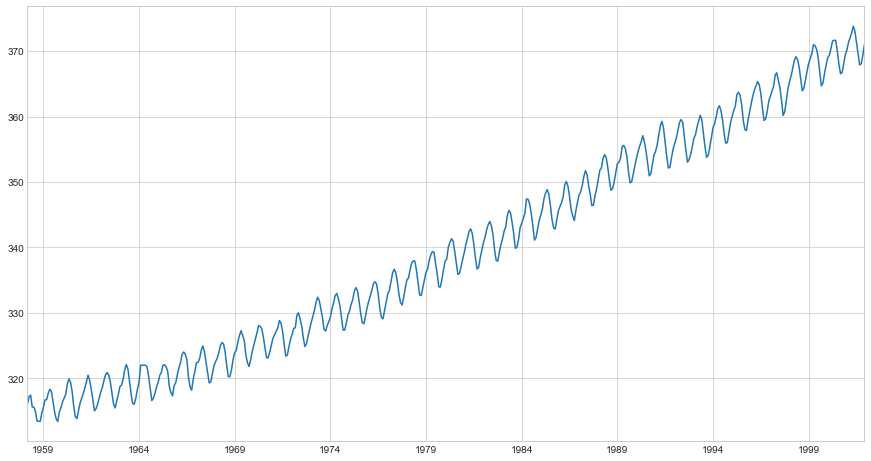

In [9]:
y.plot(figsize=(15, 8))
plt.show()

<br>

    Some distinguishable patterns appear when we plot the data. The time series has an obvious seasonality pattern, as well as an overall increasing trend.

### Step 3 — The ARIMA Time Series Model


    AutoregRessive Integrated Moving Average. ARIMA is a model that can be fitted to time series data in order to better understand or predict future points in the series.

    There are three distinct integers (p, d, q) that are used to parametrize ARIMA models. Because of that, ARIMA models are denoted with the notation ARIMA(p, d, q). Together these three parameters account for seasonality, trend, and noise in datasets:

```
p is the auto-regressive part of the model. It allows us to incorporate the effect of past values into our model. Intuitively, this would be similar to stating that it is likely to be warm tomorrow if it has been warm the past 3 days.

d is the integrated part of the model. This includes terms in the model that incorporate the amount of differencing (i.e. the number of past time points to subtract from the current value) to apply to the time series. Intuitively, this would be similar to stating that it is likely to be same temperature tomorrow if the difference in temperature in the last three days has been very small.

q is the moving average part of the model. This allows us to set the error of our model as a linear combination of the error values observed at previous time points in the past.
```

### Step 4 — Parameter Selection for the ARIMA Time Series Model

    When looking to fit time series data with a seasonal ARIMA model, our first goal is to find the values of ARIMA(p,d,q)(P,D,Q)s that optimize a metric of interest. There are many guidelines and best practices to achieve this goal, yet the correct parametrization of ARIMA models can be a painstaking manual process that requires domain expertise and time. Other statistical programming languages such as R provide automated ways to solve this issue, but those have yet to be ported over to Python. In this section, we will resolve this issue by writing Python code to programmatically select the optimal parameter values for our ARIMA(p,d,q)(P,D,Q)s time series model.

    We will use a “grid search” to iteratively explore different combinations of parameters. For each combination of parameters, we fit a new seasonal ARIMA model with the SARIMAX() function from the statsmodels module and assess its overall quality. Once we have explored the entire landscape of parameters, our optimal set of parameters will be the one that yields the best performance for our criteria of interest. Let’s begin by generating the various combination of parameters that we wish to assess:

    When dealing with seasonal effects, we make use of the seasonal ARIMA, which is denoted as ARIMA(p,d,q)(P,D,Q)s. Here, (p, d, q) are the non-seasonal parameters described above, while (P, D, Q) follow the same definition but are applied to the seasonal component of the time series. The term s is the periodicity of the time series (4 for quarterly periods, 12 for yearly periods, etc.).

    The seasonal ARIMA method can appear daunting because of the multiple tuning parameters involved. In the next section, we will describe how to automate the process of identifying the optimal set of parameters for the seasonal ARIMA time series model.

<br>

In [10]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)


# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))
#  print(pdq)
#  [(0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1), (1, 0, 0), 
#   (1, 0, 1), (1, 1, 0), (1, 1, 1)]


# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


    We can now use the triplets of parameters defined above to automate the process of training and evaluating ARIMA models on different combinations. In Statistics and Machine Learning, this process is known as grid search (or hyperparameter optimization) for model selection.

    When evaluating and comparing statistical models fitted with different parameters, each can be ranked against one another based on how well it fits the data or its ability to accurately predict future data points. We will use the AIC (Akaike Information Criterion) value, which is conveniently returned with ARIMA models fitted using statsmodels. The AIC measures how well a model fits the data while taking into account the overall complexity of the model. A model that fits the data very well while using lots of features will be assigned a larger AIC score than a model that uses fewer features to achieve the same goodness-of-fit. Therefore, we are interested in finding the model that yields the lowest AIC value.

    The code chunk below iterates through combinations of parameters and uses the SARIMAX function from statsmodels to fit the corresponding Seasonal ARIMA model. Here, the order argument specifies the (p, d, q) parameters, while the seasonal_order argument specifies the (P, D, Q, S) seasonal component of the Seasonal ARIMA model. After fitting each SARIMAX()model, the code prints out its respective AIC score.

<br>

In [11]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:7612.583429881011
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1854.8282341412219
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1596.7111727638414
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1058.9388921320021
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1056.2878764574048
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1361.6578978068437
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1044.7647902758538
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:6881.048755161931
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:6072.662327699189
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1379.1941067386633
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1241.4174716847037
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:800.4737837404643
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:780.4314256270083
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1119.5957893626069
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:807.0912986773673
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1675.8086923024293
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1240.2211199194094
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:633.4425585982868

    The output of our code suggests that SARIMAX(1, 1, 1)x(1, 1, 1, 12) yields the lowest AIC value of 277.78. We should therefore consider this to be optimal option out of all the models we have considered.

<br>

### Step 5 - Fitting an ARIMA Time Series Model

    Using grid search, we have identified the set of parameters that produces the best fitting model to our time series data. We can proceed to analyze this particular model in more depth.

    We’ll start by plugging the optimal parameter values into a new SARIMAX model:

<br>

In [12]:
# We’ll start by plugging the optimal parameter values into a new SARIMAX model:

mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[0])


                                     SARIMAX Results                                      
Dep. Variable:                                co2   No. Observations:                  526
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -133.891
Date:                            Wed, 07 Oct 2020   AIC                            277.782
Time:                                    10:50:35   BIC                            298.845
Sample:                                03-01-1958   HQIC                           286.048
                                     - 12-01-2001                                         
Covariance Type:                              opg                                         


In [13]:
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3153      0.092      3.416      0.001       0.134       0.496
ma.L1         -0.6233      0.077     -8.136      0.000      -0.773      -0.473
ar.S.L12       0.0010      0.001      1.732      0.083      -0.000       0.002
ma.S.L12      -0.8762      0.026    -33.688      0.000      -0.927      -0.825
sigma2         0.0971      0.004     22.654      0.000       0.089       0.105


    The summary attribute that results from the output of SARIMAX returns a significant amount of information, but we’ll focus our attention on the table of coefficients. The coef column shows the weight (i.e. importance) of each feature and how each one impacts the time series. The P>|z| column informs us of the significance of each feature weight. Here, each weight has a p-value lower or close to 0.05, so it is reasonable to retain all of them in our model.

    When fitting seasonal ARIMA models (and any other models for that matter), it is important to run model diagnostics to ensure that none of the assumptions made by the model have been violated. The plot_diagnostics object allows us to quickly generate model diagnostics and investigate for any unusual behavior.

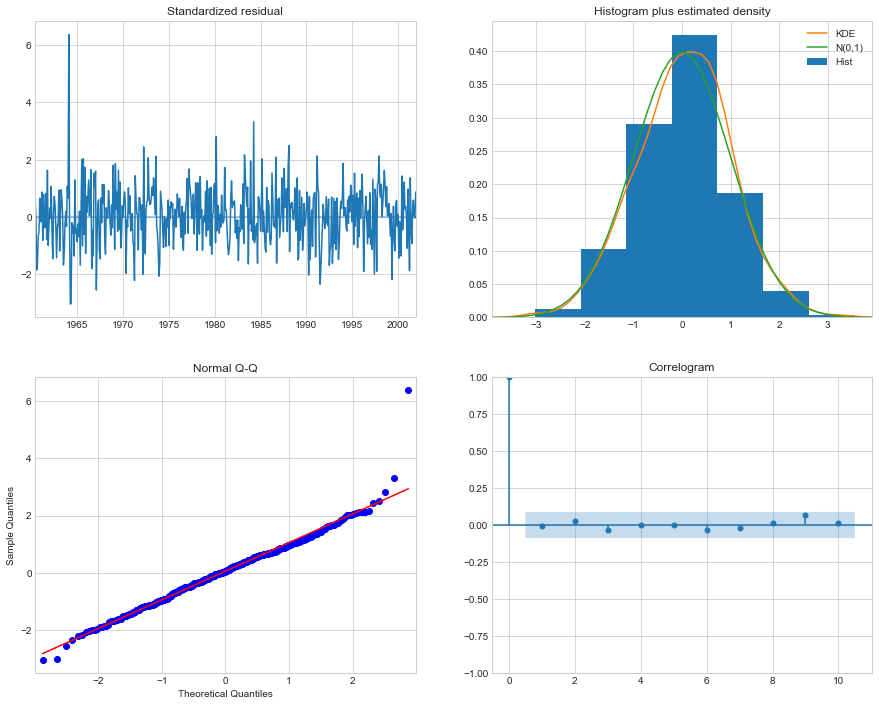

In [14]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

    Our primary concern is to ensure that the residuals of our model are uncorrelated and normally distributed with zero-mean. If the seasonal ARIMA model does not satisfy these properties, it is a good indication that it can be further improved.

_In this case, our model diagnostics suggests that the model residuals are normally distributed based on the following:_

_In the top right plot, we see that the red KDE line follows closely with the N(0,1) line (where N(0,1)) is the standard notation for a normal distribution with mean 0 and standard deviation of 1). This is a good indication that the residuals are normally distributed.
The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with N(0, 1). Again, this is a strong indication that the residuals are normally distributed.
The residuals over time (top left plot) don’t display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.
Those observations lead us to conclude that our model produces a satisfactory fit that could help us understand our time series data and forecast future values._

_Although we have a satisfactory fit, some parameters of our seasonal ARIMA model could be changed to improve our model fit. For example, our grid search only considered a restricted set of parameter combinations, so we may find better models if we widened the grid search._

<br>

###  Step 6 — Validating Forecasts


    We have obtained a model for our time series that can now be used to produce forecasts. We start by comparing predicted values to real values of the time series, which will help us understand the accuracy of our forecasts. The get_prediction() and conf_int() attributes allow us to obtain the values and associated confidence intervals for forecasts of the time series.

In [15]:
pred = results.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=False)
pred_ci = pred.conf_int()


# The code above requires the forecasts to start at January 1998.

# The dynamic=False argument ensures that we produce one-step ahead forecasts, meaning that forecasts at each point are generated using the full history up to that point.

# We can plot the real and forecasted values of the CO2 time series to assess how well we did. Notice how we zoomed in on the end of the time series by slicing the date index.




In [16]:
pred_ci

,lower co2,upper co2
1998-01-01,364.453703,365.674903
1998-02-01,365.374411,366.595611
1998-03-01,366.405555,367.626754
1998-04-01,367.909563,369.130762
1998-05-01,368.390579,369.611777
1998-06-01,367.802842,369.024040
1998-07-01,366.482353,367.703552
1998-08-01,364.754189,365.975388
1998-09-01,363.200080,364.421278
1998-10-01,363.379891,364.601090


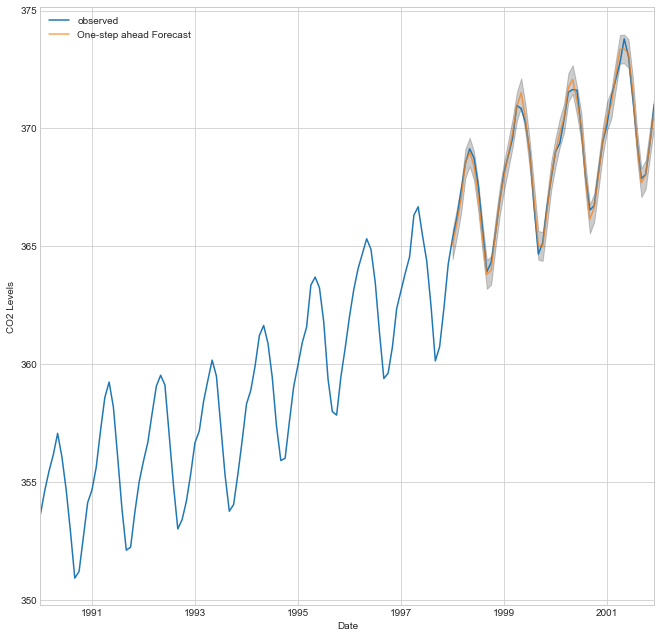

In [17]:
ax = y['1990':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, 
                        figsize=(11,11))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')
plt.legend()

plt.show()

    Overall, our forecasts align with the true values very well, showing an overall increase trend.

    It is also useful to quantify the accuracy of our forecasts. We will use the MSE (Mean Squared Error), which summarizes the average error of our forecasts. For each predicted value, we compute its distance to the true value and square the result. The results need to be squared so that positive/negative differences do not cancel each other out when we compute the overall mean.

In [18]:
y_forecasted = pred.predicted_mean
y_truth = y['1998-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.07


    The MSE of our one-step ahead forecasts yields a value of 0.07, which is very low as it is close to 0. An MSE of 0 would that the estimator is predicting observations of the parameter with perfect accuracy, which would be an ideal scenario but it not typically possible.

    However, a better representation of our true predictive power can be obtained using dynamic forecasts. In this case, we only use information from the time series up to a certain point, and after that, forecasts are generated using values from previous forecasted time points.

    In the code chunk below, we specify to start computing the dynamic forecasts and confidence intervals from January 1998 onwards.

In [19]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

    Plotting the observed and forecasted values of the time series, we see that the overall forecasts are accurate even when using dynamic forecasts. All forecasted values (red line) match pretty closely to the ground truth (blue line), and are well within the confidence intervals of our forecast.

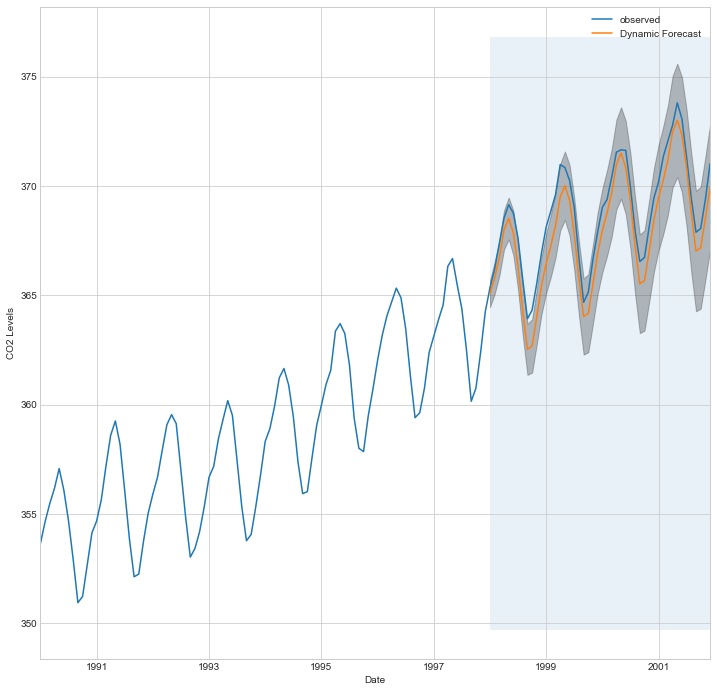

In [20]:
ax = y['1990':].plot(label='observed', figsize=(12,12))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('1998-01-01'), y.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')

plt.legend()
plt.show()

In [21]:
# Once again, we quantify the predictive performance of our forecasts by computing the MSE:

# Extract the predicted and true values of our time series
y_forecasted = pred_dynamic.predicted_mean
y_truth = y['1998-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 1.01


    The predicted values obtained from the dynamic forecasts yield an MSE of 1.01. This is slightly higher than the one-step ahead, which is to be expected given that we are relying on less historical data from the time series.

    Both the one-step ahead and dynamic forecasts confirm that this time series model is valid. However, much of the interest around time series forecasting is the ability to forecast future values way ahead in time.

### Step 7 — Producing and Visualizing Forecasts


    In the final step of this tutorial, we describe how to leverage our seasonal ARIMA time series model to forecast future values. The get_forecast() attribute of our time series object can compute forecasted values for a specified number of steps ahead.

In [22]:
# Get forecast 500 steps ahead in future
pred_uc = results.get_forecast(steps=500)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

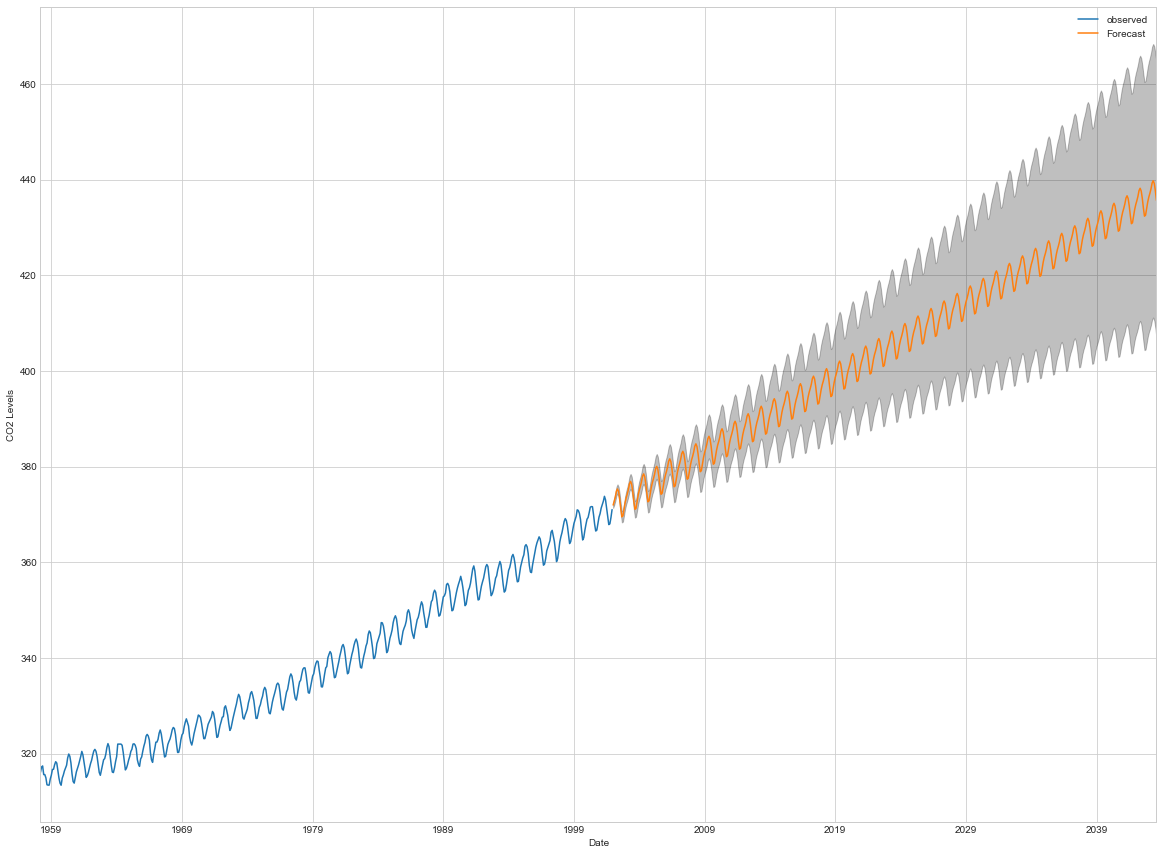

In [23]:
#@We can use the output of this code to plot the time series and forecasts of its future values.

ax = y.plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')

plt.legend()
plt.show()

    Both the forecasts and associated confidence interval that we have generated can now be used to further understand the time series and foresee what to expect. Our forecasts show that the time series is expected to continue increasing at a steady pace.

    As we forecast further out into the future, it is natural for us to become less confident in our values. This is reflected by the confidence intervals generated by our model, which grow larger as we move further out into the future.

<br><br><br>

## Going back and doing seasonal decomposition:

    Some distinguishable patterns appear when we plot the data. The time-series has an obvious seasonality pattern, as well as an overall increasing trend. We can also visualize our data using a method called time-series decomposition. As its name suggests, time series decomposition allows us to decompose our time series into three distinct components: trend, seasonality, and noise.

    Fortunately, statsmodels provides the convenient seasonal_decompose function to perform seasonal decomposition out of the box. If you are interested in learning more, the reference for its original implementation can be found in the following paper, “STL: A Seasonal-Trend Decomposition Procedure Based on Loess.”

    The script below shows how to perform time-series seasonal decomposition in Python. By default, seasonal_decompose returns a figure of relatively small size, so the first two lines of this code chunk ensure that the output figure is large enough for us to visualize.

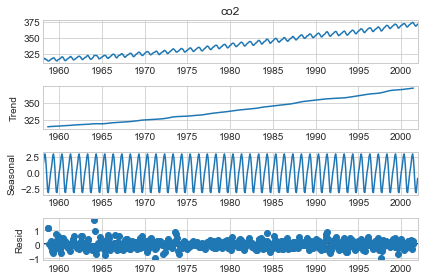

In [24]:
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

    Using time-series decomposition makes it easier to quickly identify a changing mean or variation in the data. The plot above clearly shows the upwards trend of our data, along with its yearly seasonality. These can be used to understand the structure of our time-series. The intuition behind time-series decomposition is important, as many forecasting methods build upon this concept of structured decomposition to produce forecasts.